<a href="https://colab.research.google.com/github/louis-perdrix/Modal/blob/main/TD_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 7 Generative Adversarial Networks

Credits: Maria Vakalopoulou and Leo Milecki

## Part I: GAN on MNIST dataset

In [2]:
import os
import torch
from torch import nn
from tqdm.notebook import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

### Utility function

Given a tensor of images, number of images and size per image, this function plots and prints the images on a uniform grid 

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator Class

`Generator` is a neural network that takes as input a noise vector and outputs a generated fake image of size `im_dim`=(28*28)=784.

Complete the `Generator` class with 3 blocks containing:
- A linear layer
- A BatchNorm 
- A ReLU activation

Each block doubles the size of `hidden_dim`.

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            
            nn.Linear(z_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.BatchNorm1d(2*hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(2*hidden_dim, 4*hidden_dim),
            nn.BatchNorm1d(4*hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(4*hidden_dim, 8*hidden_dim),
            nn.BatchNorm1d(8*hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(8 * hidden_dim, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

 Complete the function `get_noise` to sample a random vector following a standard normal distribution

In [5]:
def get_noise(n_samples, z_dim, device=torch.device('cpu')):
    noise = torch.randn(n_samples, z_dim, device=device)
    return noise


### Discriminator Class

The discriminator takes as input an image and outputs a 1 dimensional tensor representing fake/real.

Complete the following `Discriminator` class with the following sequence of layers:
1. A linear layer that takes an image with dim `im_dim` and outputs a vector with a dimension of 4 * `hidden_dim`
2. A linear layer that divides the dimension by two
3. A hidden layer that has an output size = `hidden_dim`
4. A linear output layer that outputs a scalar.


All of the linear layers EXCEPT the last one must be followed by a LeakyReLU with negative slope equal to 0.2

In [6]:
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(im_dim, 4*hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(4*hidden_dim, 2*hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(2*hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

Complete the following cell to create train MNIST `dataset` and `dataloader`

In [7]:
# Setting architecture
z_dim = 64
img_dim = 28**2
hidden_dim=128

# Setting optimization hyperparameters
n_epochs = 200
batch_size = 128
lr = 1e-4
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda')

# Setting logs params
display_epoch = 40

# Create MNIST dataset and dataloader 
### To complete
current_path = os.getcwd()
dataset = MNIST(
    root=current_path,
    download=True,
    train=True,
    transform=transforms.ToTensor())
dataloader = DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)
###

100%|██████████| 9912422/9912422 [00:00<00:00, 104012867.21it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39716620.93it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18392007.48it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4228752.22it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



### Initialize the Generator, the Discriminator and Optimizers

Complete the following cell to initialize the generator `gen`, the discriminator `disc` and their respective optimizers `gen_opt` and `disc_opt`.
</br>
Make sure that the code can run on gpu by moving model to the defined `device`.

In [8]:
# Initialization of the generator and discriminator 
gen = Generator(z_dim=z_dim, im_dim=img_dim, hidden_dim=hidden_dim).to(device)
disc = Discriminator(im_dim=img_dim, hidden_dim=hidden_dim).to(device)

# Initialization of their respective optimizers (Use Adam optimizer)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

print('Generator\n')
print(gen)

print('Discriminator\n')
print(disc)

Generator

Generator(
  (gen): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Sigmoid()
  )
)
Discriminator

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_sl

### Create the discriminator's loss function

Complete the function `get_disc_loss` that should compute the loss of the discriminator. It should follow these steps:
1. Create noise vectors and generate a batch (num_images) of fake images. 
   Make sure to pass the device argument to the noise.
2. Get the discriminator's prediction of the fake image 
   and calculate the loss. Don't forget to detach the generator!
   (Remember the loss function you set earlier -- criterion. You need a 
   'ground truth' tensor in order to calculate the loss. 
   For example, a ground truth tensor for a fake image is all zeros.)
3. Get the discriminator's prediction of the real image and calculate the loss.
   Do not write your own loss function, use the `criterion` function 
4. Calculate the discriminator's loss by averaging the real and fake loss
   and set it to `disc_loss`.

In [9]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    ### To complete
    # 1. Create noise vectors and generate a batch (num_images) of fake images. 
    z = get_noise(num_images, z_dim).to(device)
    fake = gen(z)
        
    # 2.Get the discriminator's prediction of the fake image and calculate the loss. 
    predict_fake = disc(fake.detach())
    ground_truth = torch.zeros((num_images, 1)).to(device)
    loss_fake = criterion(predict_fake, ground_truth)
    
    # 3. Get the discriminator's prediction of the real image and calculate the loss.
    predict_real = disc(real)
    ground_truth = torch.ones((num_images, 1)).to(device)
    loss_real = criterion(predict_real, ground_truth)
    
    # 4. Calculate the discriminator's loss by averaging the real and fake loss
    # and set it to disc_loss.
    disc_loss = (loss_fake+loss_real)/2
    ###
    return disc_loss

### Create the generator's loss function

Complete the function `get_gen_loss` that should compute the loss of the generator. It should follow these steps:
1. Create noise vectors and generate a batch of fake images. 
    Remember to pass the device argument to the `get_noise` function.
2. Get the discriminator's prediction of the fake image.
3. Calculate the generator's loss. Remember the generator wants
    the discriminator to think that its fake images are real
    Again do not write your own loss function here use `criterion`

In [10]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    ### To complete
    # 1. Create noise vectors and generate a batch (num_images) of fake images. 
    # Make sure to pass the device argument to the noise.
    z = get_noise(num_images, z_dim).to(device)
    fake = gen(z)
        
    # 2.Get the discriminator's prediction of the fake image
    predict_fake = disc(fake)
    
    # 3. Calculate the generator's loss. 
    ground_truth = torch.ones((num_images, 1)).to(device)
    gen_loss = criterion(predict_fake, ground_truth)
    return gen_loss

### Question: 
The following graph plots the generator's and discriminator's losses during the training of a GAN. Why does the Generator's loss go up after approximately 3000 iterations ?

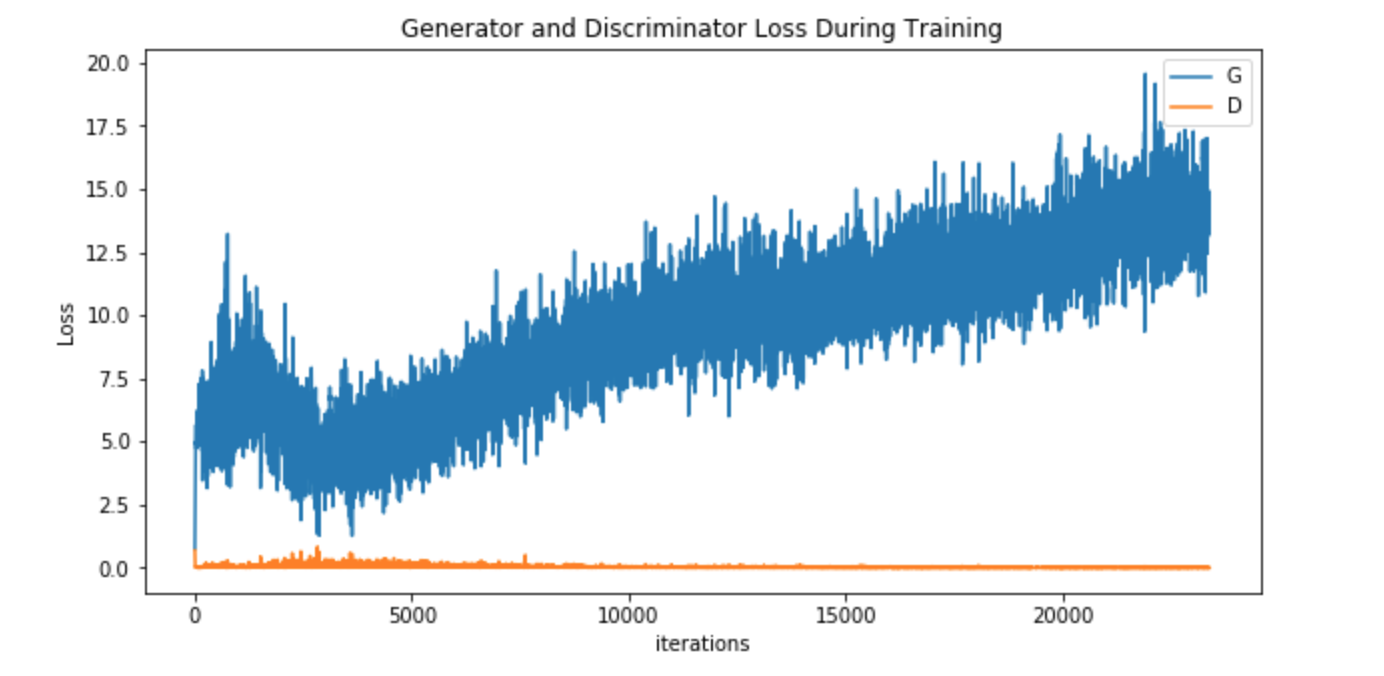




Reponse a la question: apres 3000 iterations, le discriminator est bien entraine donc il repere mieux les vraies images des fausses. Donc la loss du generator ne peut pas croitre indefiniment et finit par reaugmenter. 
On peut par exemple avoir de l'overfitting sur le Discriminator.

### GAN training

Within the following training loop, for each batch iteration, complete the code to:

1. Train the discriminator by
    1. Zero out discriminator gradients 
    2. Compute discriminator loss on real + fake images
    3. Compute discriminator loss gradients with respect to discrimator parameters
    4. Update discriminator parameters
    
2. Train the generator by
    1. Zero out generator gradients 
    2. Compute generator loss on fake images
    3. Compute generator loss gradients with respect to generator parameters
    4. Update generator parameters

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

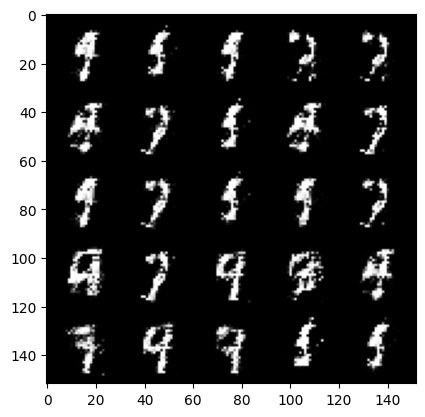

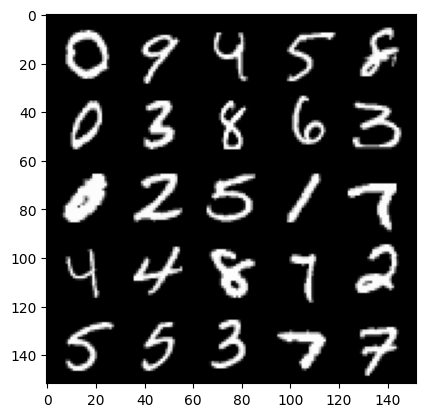

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

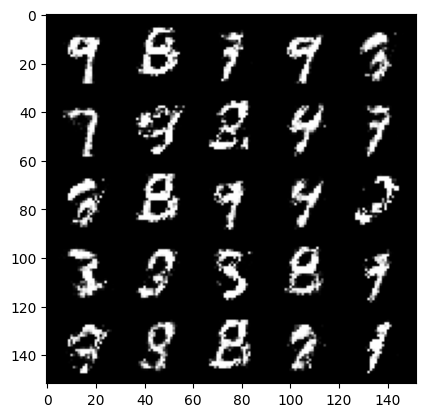

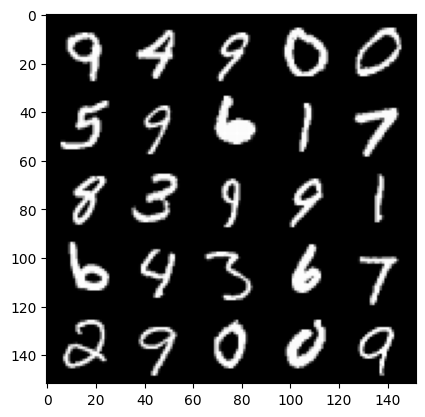

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

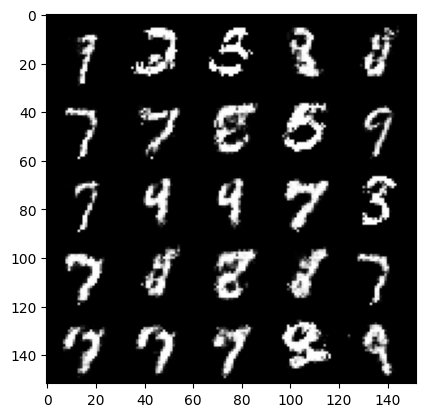

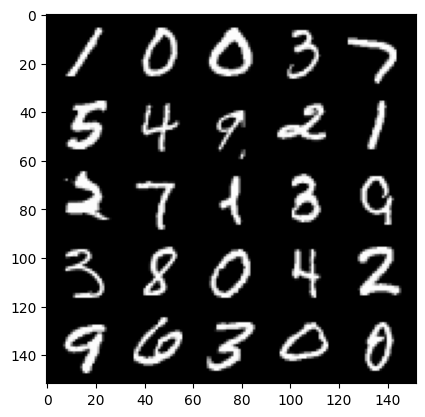

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

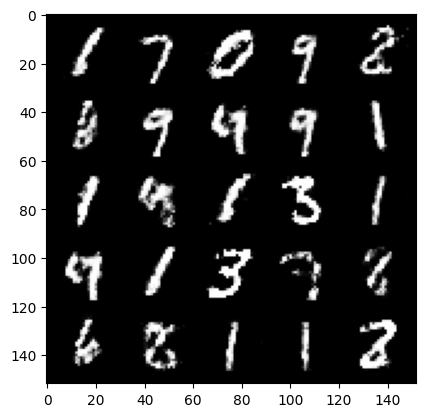

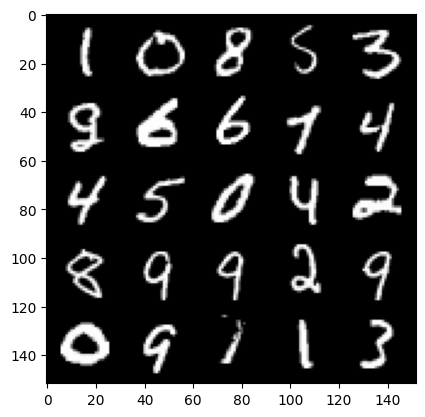

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

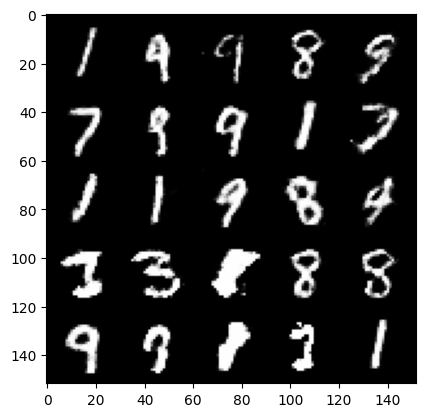

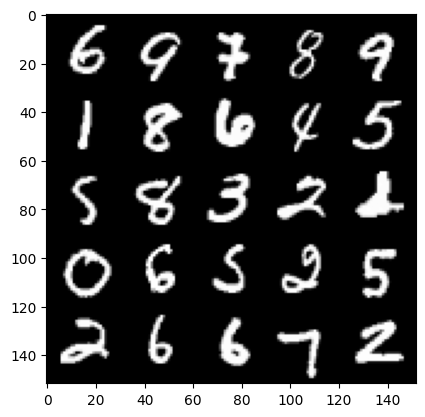

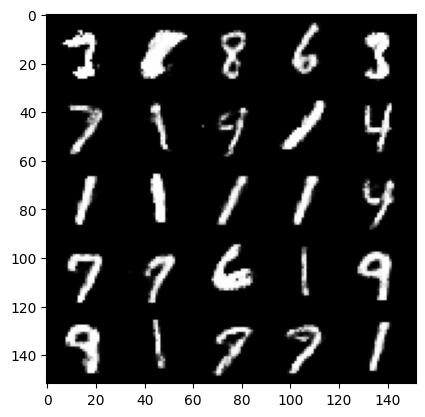

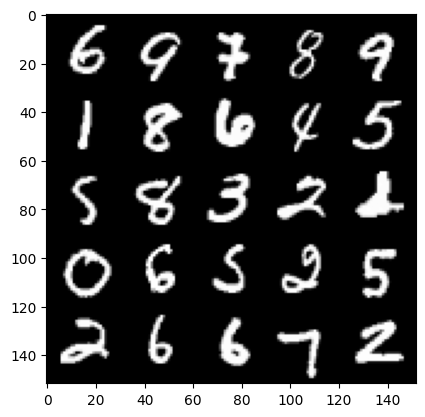

In [ ]:
G_losses = []
D_losses = []

for epoch in range(1, n_epochs+1):
  
    # Dataloader returns the batches and tqdm is just a wrapper to add a progressbar
    # when iterating over the dataloader
    dloader = tqdm(dataloader, unit='batches')
    # Initialize tracked metrics
    sum_generator_loss = 0
    sum_discriminator_loss = 0
    
    for batch_index, (real, _) in enumerate(dloader, start=1):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # A. Zero out generator gradients
        disc_opt.zero_grad()

        # B. Compute discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # C. Compute discriminator loss gradients with respect to discriminator params 
        disc_loss.backward()

        # D. Update discriminator params
        disc_opt.step()
        
        
        ## 2. Generator training
        # A. Zero out generator gradients
        gen_opt.zero_grad()
        
        # B. Compute generator loss on fake images
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)


        # C. Compute generator loss gradients with respect to generator params 
        gen_loss.backward()

        # D. Update generator params
        gen_opt.step()


        # Keep track of the average discriminator loss
        sum_discriminator_loss += disc_loss.item()
        mean_discriminator_loss = sum_discriminator_loss/batch_index

        # Keep track of the average generator loss
        sum_generator_loss += gen_loss.item()
        mean_generator_loss = sum_generator_loss/batch_index

        # Save Losses for plotting later
        G_losses.append(mean_generator_loss)
        D_losses.append(mean_discriminator_loss)
        
        # Update progress bar to see metrics during training
        desc = "Epoch {}/{}: gen loss: {:.3f}, disc loss: {:.3f}".format(epoch, n_epochs, mean_generator_loss, mean_discriminator_loss)
        dloader.set_description(desc)

    # Visualization code
    if epoch % display_epoch == 0:
        gen.eval()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake)
        show_tensor_images(real)
        gen.train()

# For last iteration plot real + fake images
gen.eval()
fake_noise = get_noise(cur_batch_size, z_dim, device=device)
fake = gen(fake_noise)
show_tensor_images(fake)
show_tensor_images(real)

### Plot the Generator and Discriminator losses

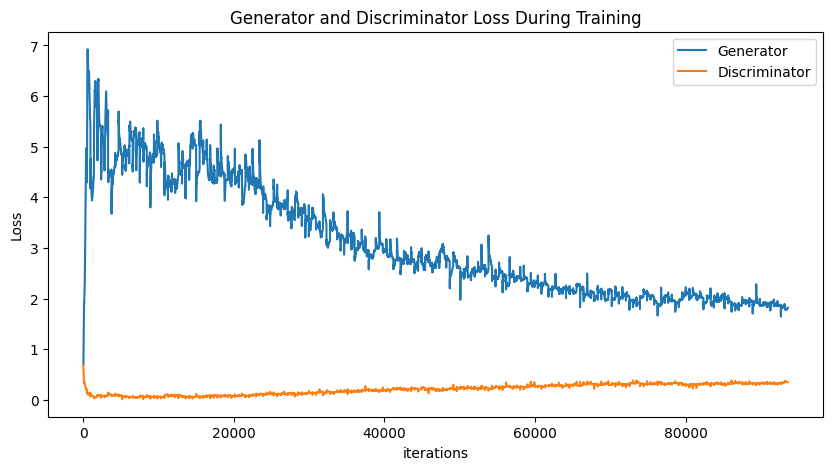

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Part II: Deep Convolutional Generative Adversarial Network (DCGAN)

Original paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434v1.pdf)

Complete the `DCGenerator` class with the following architecture: 
- Block 1: 
    - A transposed convolution that takes `z_dim` input channels and outputs `4*hidden_dim` (with kernel_size of 3 and stride of 2)
    - A batch normalization
    - A ReLU
- Block 2: 
    - A transposed convolution that takes `4*hidden_dim` as input and outputs `2*hidden_dim` (with kernel_size of 4 and stride of 1)
    - A batch normalization
    - A ReLU
- Block 3: 
    - A transposed convolution that takes `2*hidden_dim` as input and outputs `hidden_dim` (with kernel_size of 3 and stride of 2)
    - A batch normalization
    - A ReLU
- Block 4: 
    - A transposed convolution that takes `hidden_dim` as input and outputs `im_chan` (with kernel_size of 4 and stride of 2)
    - A Tanh

In [11]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(DCGenerator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        
        self.gen = nn.Sequential(
            # Block1
            nn.ConvTranspose2d(z_dim, 4*hidden_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(4*hidden_dim),
            nn.ReLU(inplace=True),
            
            # Block2
            nn.ConvTranspose2d(4*hidden_dim, 2*hidden_dim, kernel_size=4, stride=1),
            nn.BatchNorm2d(2*hidden_dim),
            nn.ReLU(inplace=True),
            
            # Block3
            nn.ConvTranspose2d(2*hidden_dim, hidden_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            
            # Block4
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def unsqueeze_noise(self, noise):
        return noise.view(noise.size(0), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device=torch.device('cpu')):
    return torch.randn(n_samples, z_dim, device=device)

Complete the `DCDiscrimnator` class with the following architecture: 
- Block 1: 
    - A convolution that outputs `hidden_dim` (with kernel_size of 4 and stride of 2)
    - a batch normalization
    - A LeakyReLU with negative slope of 0.2
- Block 2: 
    - A convolution that outputs `2 * hidden_dim` (with kernel_size of 4 and stride of 2)
    - A batch normalization
    - A LeakyReLU with negative slope of 0.2
- Block 3: 
    - A final convolution (with kernel_size of 4 and stride of 2) that outputs a scalar

In [12]:
class DCDiscriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(DCDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            # Block1
            nn.Conv2d(im_chan, hidden_dim, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # Block2
            nn.Conv2d(hidden_dim, 2*hidden_dim, kernel_size=4, stride=2),
            nn.BatchNorm2d(2*hidden_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # Block3
            nn.Conv2d(2*hidden_dim, 1, kernel_size=4, stride=2)
       )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [13]:
# Define architecture and optimization hyperparams
z_dim = 64
hidden_dim = 16
n_epochs = 120
batch_size = 128
display_epoch = 20
lr = 1e-4
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda')

# These parameters control the optimizer's momentum, which you can read more about here: https://distill.pub/2017/momentum/
beta_1 = 0.5 
beta_2 = 0.999

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create a dataloader from MNIST 
current_path = os.getcwd()
dataset = MNIST(
    root=current_path,
    download=True,
    train=True,
    transform=transform)
dataloader = DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)

Complete the following cell to initialize the generator `gen`, the discriminator `disc` and their respective optimizers `gen_opt` and `disc_opt`.
</br>
Make sure that the code can run on gpu by moving model to the defined `device`.

In [14]:
# Initialize the DCGenerator + DCDiscriminator
### To complete
dcgen = DCGenerator(z_dim=z_dim, hidden_dim=hidden_dim).to(device)
dcdisc = DCDiscriminator(hidden_dim=hidden_dim).to(device)

# Initialize their respective optimizer (Use Adam optimizer with defined hyperparams beta_1, beta_2)
### To complete
dcgen_opt = torch.optim.Adam(dcgen.parameters(), lr=lr, betas = (beta_1, beta_2))
dcdisc_opt = torch.optim.Adam(dcdisc.parameters(), lr=lr, betas = (beta_1, beta_2))

# Initialize generator and discriminator weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## DCGAN training

Within the following training loop, for each batch iteration, complete the code to:

1. Train the discriminator by
    1. Zero out discriminator gradients 
    2. Generate fake images + Compute discriminator loss as average of the losses on real and fake images.
    3. Compute discriminator loss gradients with respect to discriminator parameters
    4. Update discriminator parameters
    
2. Train the generator by
    1. Zero out generator gradients 
    2. Compute discriminator's output on fake images + compute generator loss on fake images
    3. Compute generator loss gradients with respect to generator parameters
    4. Update generator parameters

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

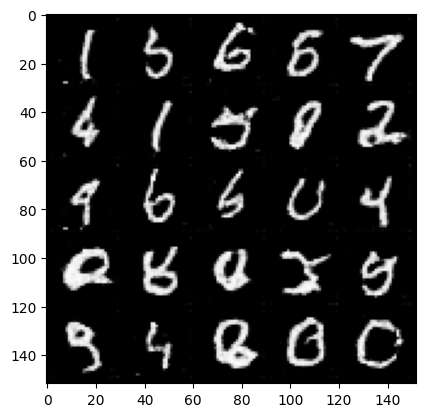

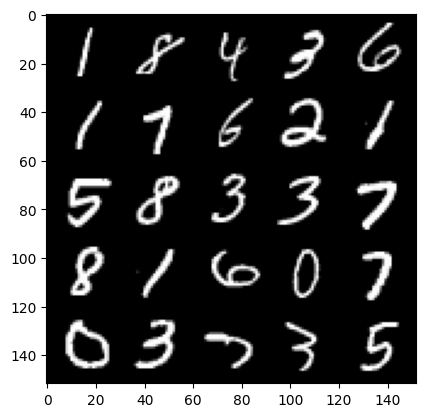

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

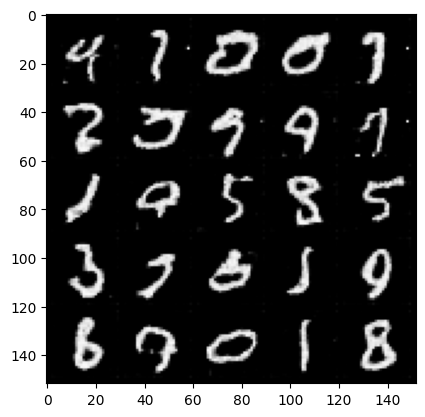

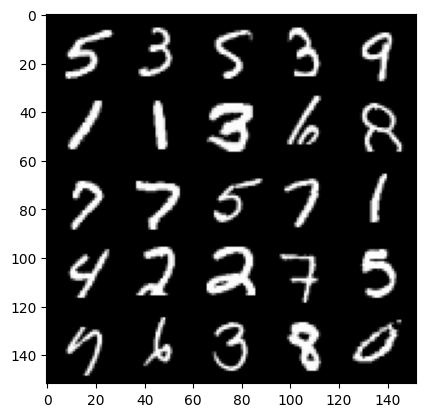

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

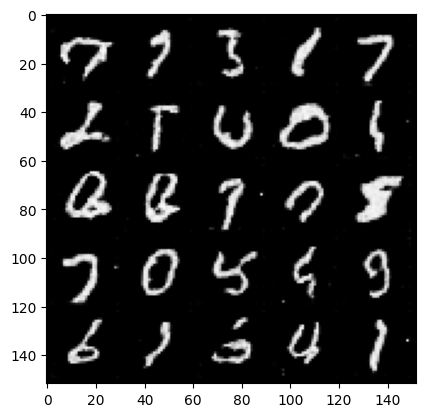

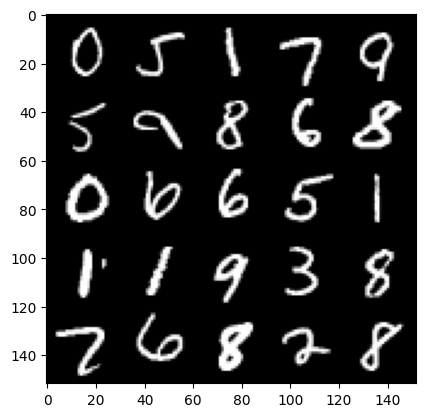

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

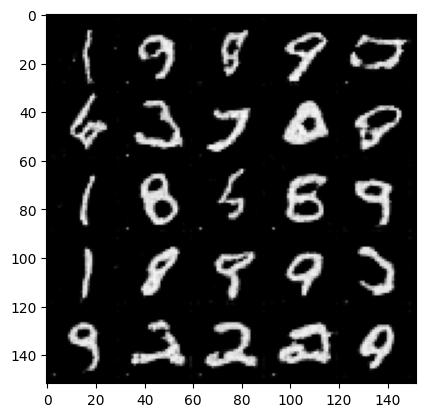

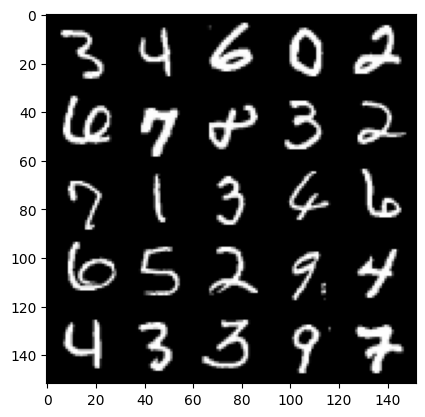

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

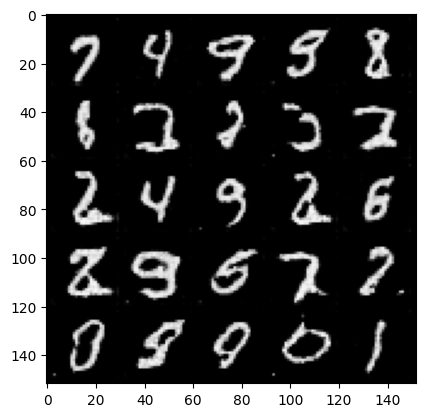

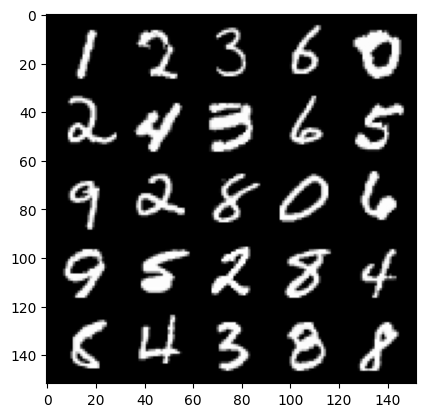

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

  0%|          | 0/468 [00:00<?, ?batches/s]

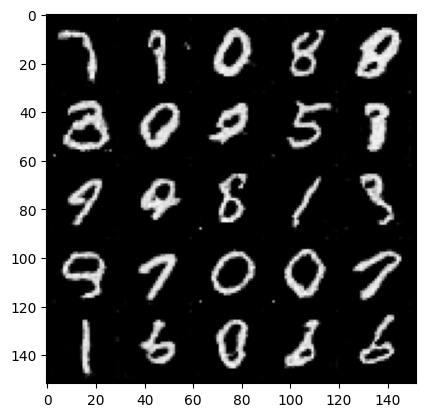

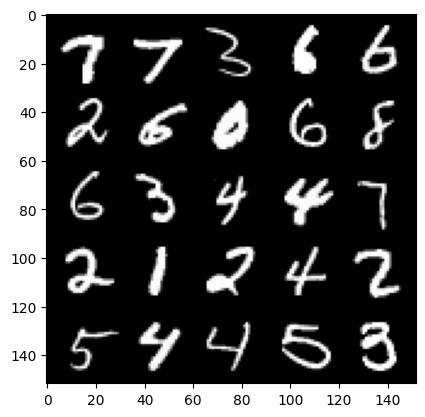

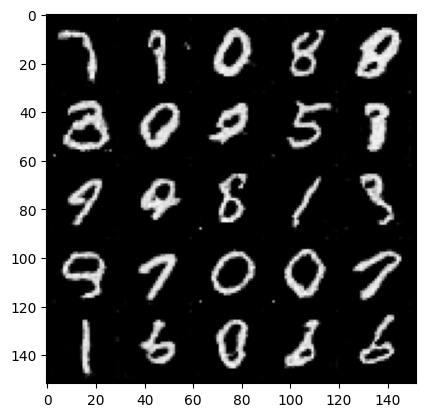

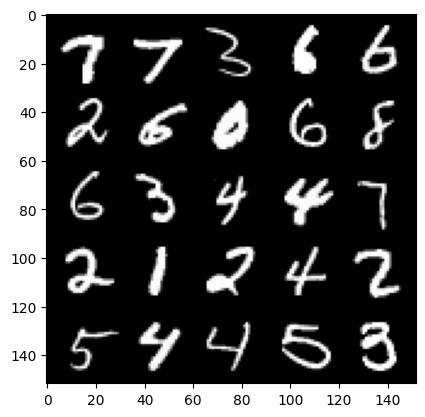

In [18]:
for epoch in range(1, n_epochs+1):
    
    # Dataloader returns the batches and tqdm is just a wrapper to add a progressbar
    # when iterating over the dataloader
    dloader = tqdm(dataloader, unit='batches')
    # Initialize tracked metrics
    sum_generator_loss = 0
    sum_discriminator_loss = 0
    
    # Dataloader returns the batches
    for batch_index, (real, _) in enumerate(dloader, start=1):
        cur_batch_size = len(real)
        real = real.to(device)

        
        ############## To complete
        
        ## 1. Train discriminator
        #   A. Zero out the discriminator's gradients
        dcdisc_opt.zero_grad()
        
        #   B. Generate fake images + Compute discriminator loss as average of the losses on real and fake images.
        z = get_noise(cur_batch_size, z_dim).to(device)
        fake = dcgen(z)
            
        predict_fake = dcdisc(fake.detach())
        ground_truth = torch.zeros((cur_batch_size, 1)).to(device)
        loss_fake = criterion(predict_fake, ground_truth)
        
        predict_real = dcdisc(real)
        ground_truth = torch.ones((cur_batch_size, 1)).to(device)
        loss_real = criterion(predict_real, ground_truth)
        
        disc_loss = (loss_fake+loss_real)/2
        
        #   C. Compute discriminator loss gradients with respect to discriminator parameters
        disc_loss.backward()
        
        #   D. Update discriminator parameters
        dcdisc_opt.step()
        
        # Keep track of the average discriminator loss
        sum_discriminator_loss += disc_loss.item()
        mean_discriminator_loss = sum_discriminator_loss / batch_index
        
        ## 2. Train generator
        
        #   A. Zero out generator gradients
        dcgen_opt.zero_grad()
        
        #   B. Compute discriminator's output on fake images + compute generator loss on fake images
        gen_loss = get_gen_loss(dcgen, dcdisc, criterion, cur_batch_size, z_dim, device)
        
        #   C. Compute generator loss gradients with respect to generator parameters
        gen_loss.backward()
        
        #   D. Update generator parameters
        dcgen_opt.step()
        
        ##############
        
        # Keep track of the average generator loss
        sum_generator_loss += gen_loss.item()
        mean_generator_loss = sum_generator_loss / batch_index
        
        # Update progress bar to see metrics during training
        desc = "Epoch {}/{}: gen loss: {:.3f}, disc loss: {:.3f}".format(epoch, n_epochs, mean_generator_loss, mean_discriminator_loss)
        dloader.set_description(desc)
        
    # Visualization code
    if epoch % display_epoch == 0:
        # Rescale images into [0, 1] before plotting
        show_tensor_images((fake+1)/2)
        show_tensor_images((real+1)/2)
            
# For last iteration plot real and fake images
# Rescale images into [0, 1] before plotting
show_tensor_images((fake+1)/2)
show_tensor_images((real+1)/2)

## Part III: Explore some pretrained GANs

When you are not limited by computational power and have your own GPUs to play with, possibilities with GANs are inifinite. In this section we'll explore what has been done by the community. 

If you want to see some realistic looking high definition images of humans, cats, ... that were generated using GANs, check out one of the following project:
- https://nvlabs.github.io/stylegan3/
- https://www.thispersondoesnotexist.com/
- https://thiscatdoesnotexist.com/

Also, you can play with https://www.whichfaceisreal.com/ to see how good of a discriminator you can be. 

### BigGAN pretrained
HuggingFace open sourced an op-for-op PyTorch reimplementation of DeepMind's BigGAN using their pre-trained weights. In this part we will install the pretrained BigGAN and generated a couple of images with it.

In [ ]:
# install pytorch biggan
!pip install pytorch-pretrained-biggan

In [ ]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_int, truncated_noise_sample)
import torchvision.utils as vutils
import numpy as np
import IPython.display
from PIL import Image

In [ ]:
G = BigGAN.from_pretrained('biggan-deep-256')

In the above cell play around with the truncation parameter as well as change the integer in `one_hot_from_int()` in order to be able to generate images from different classes 

In [ ]:
# Prepare a input
truncation = 0.4
class_vector = one_hot_from_int(999, batch_size=4)# CHANGE INT HERE (it must be between 0 and 999. I suggest you try 999, it's something popular during covid times)

# The Truncation Trick is a latent sampling procedure for generative adversarial networks, 
# where we sample  from a truncated normal (where values which fall outside a range are 
# resampled to fall inside that range). In BigGAN, the authors find this provides a boost to the Inception Score and FID.
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=4, seed=1)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
G.to('cuda')

# Generate an image
with torch.no_grad():
    output = G(noise_vector, class_vector, truncation)

image_grid = vutils.make_grid(
    output,
    nrow=len(noise_vector),
    normalize=True,
)

In [ ]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)

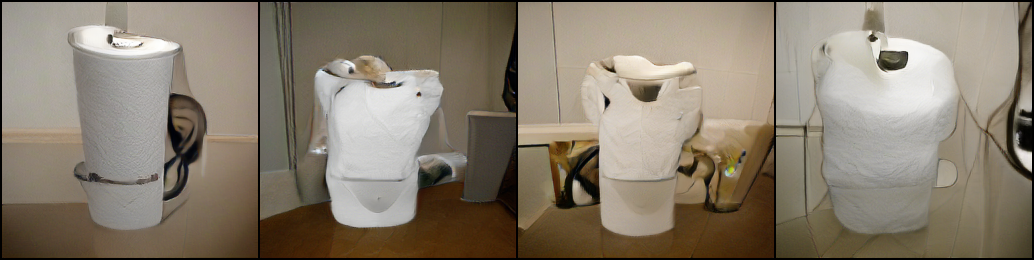

In [ ]:
IPython.display.display(Image.fromarray(image_grid_np))